In [1]:
from sumo_python.helpers.load_experiment_metadata import load_experiment_config

input_path = "/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/"

config, sim_setup = load_experiment_config(config=input_path + 'config.json',
                        sim_setup=input_path + 'simulation_setups.json',)

In [2]:
import numpy as np
import pandas as pd

from sumo_python.helpers.generate_od_xml import generate_od_xml
from sumo_python.simulator.run_sumo_and_parse_output import run_sumo_and_parse_output
from sumo_python.simulator.ground_truth import run_ground_truth_and_parse
from sumo_python.helpers.nrmse_counts import compute_nrmse_counts

df_gt_data = run_ground_truth_and_parse(config, sim_setup)


od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.gt_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml 
Success.
sumo --output-prefix gt_ --ignore-route-errors=true --net-file=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml --routes=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml -b 54000 -e 57600 --additional-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml --duration-log.statistics --xml-validation never --vehroutes /Users/rodrse/Documents/DemandCalibration/notebooks

### BO with BAxUS and TS/EI
Weimplement Bayesian optimization with adaptively expanding subspaces (BAxUS) in a closed loop in BoTorch. This is purposefully similar to the TuRBO tutorial to highlight the differences in the implementations.

Source: https://botorch.org/tutorials/baxus

In [3]:
import math
import os
from dataclasses import dataclass

import botorch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine

from botorch.acquisition.analytic import ExpectedImprovement
from botorch.exceptions import ModelFittingError
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Branin

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

Running on cpu


In [4]:
import numpy as np
import pandas as pd
def objective(x: np.array) -> pd.DataFrame:
    """Compute objective variable. This is the NRMSE loss between ground-truth output
    and the output of the simulation output evaluated at x.

    Args:
        x (np.array): Numpy array of counts to generate TAZ file from.

    Returns:
        pd.Dataframe: Data frame of sampling locations and loss esimate.
    """
    prefix_run = 'iter'    
    generate_od_xml(x, config, sim_setup, prefix_run)
    df_simulated = run_sumo_and_parse_output(config, sim_setup, prefix_run)
    loss_estimate = compute_nrmse_counts(df_gt_data, df_simulated)
    df_output = pd.DataFrame(x.reshape(-1, len(x)),columns = ['x1','x2','x3','x4'])
    df_output['loss_estimate'] = loss_estimate
    
    return df_output

### Maintain the BAxUS state


BAxUS needs to maintain a state, which includes the length of the trust region, success and failure counters, success and failure tolerance, etc. In contrast to TuRBO, the failure tolerance depends on the target dimensionality.

In this tutorial we store the state in a dataclass and update the state of TuRBO after each batch evaluation.

Note: These settings assume that the domain has been scaled to [−1,1]𝑑



In [5]:
@dataclass
class BaxusState:
    dim: int
    eval_budget: int
    new_bins_on_split: int = 3
    d_init: int = float("nan")  # Note: post-initialized
    target_dim: int = float("nan")  # Note: post-initialized
    n_splits: int = float("nan")  # Note: post-initialized
    length: float = 0.8
    length_init: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    success_counter: int = 0
    success_tolerance: int = 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        n_splits = round(math.log(self.dim, self.new_bins_on_split + 1))
        self.d_init = 1 + np.argmin(
            np.abs(
                (1 + np.arange(self.new_bins_on_split))
                * (1 + self.new_bins_on_split) ** n_splits
                - self.dim
            )
        )
        self.target_dim = self.d_init
        self.n_splits = n_splits

    @property
    def split_budget(self) -> int:
        return round(
            -1
            * (self.new_bins_on_split * self.eval_budget * self.target_dim)
            / (self.d_init * (1 - (self.new_bins_on_split + 1) ** (self.n_splits + 1)))
        )

    @property
    def failure_tolerance(self) -> int:
        if self.target_dim == self.dim:
            return self.target_dim
        k = math.floor(math.log(self.length_min / self.length_init, 0.5))
        split_budget = self.split_budget
        return min(self.target_dim, max(1, math.floor(split_budget / k)))


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

#### Create a BAxUS embedding

We now show how to create the BAxUS embedding. The essential idea is to assign input dimensions to target dimensions and to assign a sign +/- 1
 to each input dimension, similar to the HeSBO embedding. We create the embedding matrix that is used to project points from the target to the input space. The matrix is sparse, each column has precisely one non-zero entry that is either 1 or -1.

In [6]:
def embedding_matrix(input_dim: int, target_dim: int) -> torch.Tensor:
    if (
        target_dim >= input_dim
    ):  # return identity matrix if target size greater than input size
        return torch.eye(input_dim, device=device, dtype=dtype)

    input_dims_perm = (
        torch.randperm(input_dim, device=device) + 1
    )  # add 1 to indices for padding column in matrix

    bins = torch.tensor_split(
        input_dims_perm, target_dim
    )  # split dims into almost equally-sized bins
    bins = torch.nn.utils.rnn.pad_sequence(
        bins, batch_first=True
    )  # zero pad bins, the index 0 will be cut off later

    mtrx = torch.zeros(
        (target_dim, input_dim + 1), dtype=dtype, device=device
    )  # add one extra column for padding
    mtrx = mtrx.scatter_(
        1,
        bins,
        2 * torch.randint(2, (target_dim, input_dim), dtype=dtype, device=device) - 1,
    )  # fill mask with random +/- 1 at indices

    return mtrx[:, 1:]  # cut off index zero as this corresponds to zero padding


embedding_matrix(10, 3)  # example for an embedding matrix

tensor([[ 0.,  1.,  1.,  0.,  0., -1.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0., -1.],
        [ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  0.]],
       dtype=torch.float64)

### Function to increase the embedding

Next, we write a helper function to increase the embedding and to bring observations to the increased target space.



In [7]:
def increase_embedding_and_observations(
    S: torch.Tensor, X: torch.Tensor, n_new_bins: int
) -> torch.Tensor:
    assert X.size(1) == S.size(0), "Observations don't lie in row space of S"

    S_update = S.clone()
    X_update = X.clone()

    for row_idx in range(len(S)):
        row = S[row_idx]
        idxs_non_zero = torch.nonzero(row)
        idxs_non_zero = idxs_non_zero[torch.randperm(len(idxs_non_zero))].squeeze()

        non_zero_elements = row[idxs_non_zero].squeeze()

        n_row_bins = min(
            n_new_bins, len(idxs_non_zero)
        )  # number of new bins is always less or equal than the contributing input dims in the row minus one

        new_bins = torch.tensor_split(idxs_non_zero, n_row_bins)[
            1:
        ]  # the dims in the first bin won't be moved
        elements_to_move = torch.tensor_split(non_zero_elements, n_row_bins)[1:]

        new_bins_padded = torch.nn.utils.rnn.pad_sequence(
            new_bins, batch_first=True
        )  # pad the tuples of bins with zeros to apply _scatter
        els_to_move_padded = torch.nn.utils.rnn.pad_sequence(
            elements_to_move, batch_first=True
        )

        S_stack = torch.zeros(
            (n_row_bins - 1, len(row) + 1), device=device, dtype=dtype
        )  # submatrix to stack on S_update

        S_stack = S_stack.scatter_(
            1, new_bins_padded + 1, els_to_move_padded
        )  # fill with old values (add 1 to indices for padding column)

        S_update[
            row_idx, torch.hstack(new_bins)
        ] = 0  # set values that were move to zero in current row

        X_update = torch.hstack(
            (X_update, X[:, row_idx].reshape(-1, 1).repeat(1, len(new_bins)))
        )  # repeat observations for row at the end of X (column-wise)
        S_update = torch.vstack(
            (S_update, S_stack[:, 1:])
        )  # stack onto S_update except for padding column

    return S_update, X_update

In [8]:
S = embedding_matrix(10, 2)
X = torch.randint(100, (7, 2))
print(f"S before increase\n{S}")
print(f"X before increase\n{X}")

S, X = increase_embedding_and_observations(S, X, 3)
print(f"S after increase\n{S}")
print(f"X after increase\n{X}")

S before increase
tensor([[ 0.,  1.,  0., -1.,  0.,  1.,  0.,  0., -1., -1.],
        [-1.,  0.,  1.,  0., -1.,  0.,  1., -1.,  0.,  0.]],
       dtype=torch.float64)
X before increase
tensor([[ 8, 14],
        [ 7, 27],
        [81, 52],
        [71, 53],
        [66, 97],
        [37, 29],
        [68,  2]])
S after increase
tensor([[ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
       dtype=torch.float64)
X after increase
tensor([[ 8, 14,  8,  8, 14, 14],
        [ 7, 27,  7,  7, 27, 27],
        [81, 52, 81, 81, 52, 52],
        [71, 53, 71, 71, 53, 53],
        [66, 97, 66, 66, 97, 97],
        [37, 29, 37, 37, 29, 29],
        [68,  2, 68, 68,  2,  2]])


### Take a look at the state

In [9]:
state = BaxusState(dim=4, eval_budget=500)
print(state)

BaxusState(dim=4, eval_budget=500, new_bins_on_split=3, d_init=1, target_dim=1, n_splits=1, length=0.8, length_init=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, success_counter=0, success_tolerance=3, best_value=-inf, restart_triggered=False)


### Generate initial points

#### Generate new batch
Given the current state and a probabilistic (GP) model built from observations X and Y, we generate a new batch of points.

This method works on the domain [−1,+1]^d
, so make sure to not pass in observations from the true domain. unnormalize is called before the true function is evaluated which will first map the points back to the original domain.

We support either TS and qEI which can be specified via the acqf argument.

In [10]:
def create_candidate(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [-1, 1]^d
    Y,  # Function values
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= -1.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.detach().view(-1)
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length, -1.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length, -1.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=1)

    elif acqf == "ei":
        ei = ExpectedImprovement(model, train_Y.max(), maximize=True)
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=1,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

### Optimization loop

This simple loop runs one instance of BAxUS with Thompson sampling until convergence.

BAxUS works on a fixed evaluation budget and shrinks the trust region until the minimal trust region size is reached (state["restart_triggered"] is set to True). Then, BAxUS increases the target space and carries over the observations to the updated space.

In [11]:
bounds = torch.tensor([[400,400,400,400],[1000,1000,1000,1000]], device=device, dtype=dtype) 


In [16]:
def normalize(x,bounds):
    lb = bounds[0]
    ub = bounds[-1]

    a = -(ub + lb)/(ub-lb)
    b = 2/(ub - lb)

    return a + b*x
    

def unnormalize(x,bounds):
    lb = bounds[0]
    ub = bounds[-1]

    a = (ub + lb)/2
    b = (ub - lb)/2

    return a + b*x


In [17]:
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = (
        2 * sobol.draw(n=n_pts).to(dtype=dtype, device=device) - 1
    )  # points have to be in [-1, 1]^d
    return X_init

In [18]:

dim = 4
n_init = 20
evaluation_budget = 100

state = BaxusState(dim=dim, eval_budget=evaluation_budget - n_init)
S = embedding_matrix(input_dim=state.dim, target_dim=state.d_init)

X_baxus_target = get_initial_points(state.d_init, n_init)
X_baxus_input = X_baxus_target @ S


In [19]:

sumo_output = [
    objective(x) for x in unnormalize(X_baxus_input,bounds).cpu().detach().numpy()
]

df_0 = pd.concat(sumo_output)
df_0['iter'] = 0

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~105428.57UPS, vehicles TOT 2798 ACT 738 BUF 0)         
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~92000.00UPS, vehicles TOT 2757 ACT 736 BUF 41)         
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (6ms ~= 166.67*RT, ~151166.67UPS, vehicles TOT 2574 ACT 907 BUF 224)       
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~105200.00UPS, vehicles TOT 2798 ACT 526 BUF 0)      

In [20]:
SMOKE_TEST = False

In [21]:
### Run loop
NITER = 100
output = [df_0]
best_value = []
S_matrix = [S]


NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4
max_cholesky_size = float("inf")  # Always use Cholesky

Y_baxus = -1.0 * torch.from_numpy(df_0[["loss_estimate"]].values)
(Y_baxus - Y_baxus.mean()) / Y_baxus.std()


tensor([[ 0.2459],
        [ 0.0395],
        [-1.9863],
        [ 0.5816],
        [ 1.4571],
        [-1.0912],
        [-0.8915],
        [ 1.0500],
        [ 0.9052],
        [-0.5030],
        [-1.1829],
        [ 1.1912],
        [ 0.7328],
        [-1.0556],
        [-0.1357],
        [ 0.6785],
        [ 0.5954],
        [-0.1363],
        [-1.4571],
        [ 0.9624]], dtype=torch.float64)

In [22]:

# Disable input scaling checks as we normalize to [-1, 1]
with botorch.settings.validate_input_scaling(False):

    for i in range(evaluation_budget - n_init):  # Run until evaluation budget depleted
    #for i in range(2):  # Run until evaluation budget depleted

        print(f"####### {i+1} ########")

        # best value so far
        best_y = Y_baxus.max()
        best_value.append(best_y)

        print(f"##### best_value={best_y} #####")

        # Fit a GP model
        train_Y = (Y_baxus - Y_baxus.mean()) / Y_baxus.std()
        likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
        covar_module = (
            ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
                MaternKernel(
                    nu=2.5,
                    ard_num_dims=state.target_dim,
                    lengthscale_constraint=Interval(0.005, 10),
                ),
                outputscale_constraint=Interval(0.05, 10),
            )
        )
        model = SingleTaskGP(
            X_baxus_target, train_Y, covar_module=covar_module, likelihood=likelihood
        )
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        # Do the fitting and acquisition function optimization inside the Cholesky context
        with gpytorch.settings.max_cholesky_size(max_cholesky_size):
            # Fit the model
            try:
                fit_gpytorch_mll(mll)
            except ModelFittingError:
                # Right after increasing the target dimensionality, the covariance matrix becomes indefinite
                # In this case, the Cholesky decomposition might fail due to numerical instabilities
                # In this case, we revert to Adam-based optimization
                optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=0.1)

                for _ in range(100):
                    optimizer.zero_grad()
                    output = model(X_baxus_target)
                    loss = -mll(output, train_Y.flatten())
                    loss.backward()
                    optimizer.step()

            # Create a batch
            X_next_target = create_candidate(
                state=state,
                model=model,
                X=X_baxus_target,
                Y=train_Y,
                n_candidates=N_CANDIDATES,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                acqf="ts",
            )

        X_next_input = X_next_target @ S

        # Query simulator
        sumo_output_next = [
            objective(x) for x in unnormalize(X_next_input,bounds).cpu().detach().numpy()
        ]

        df_i = pd.concat(sumo_output_next)
        df_i['iter'] = i+1

        Y_next = -1.0 * torch.from_numpy(df_i[["loss_estimate"]].values)

        # Update state
        state = update_state(state=state, Y_next=Y_next)

        # Append data
        X_baxus_input = torch.cat((X_baxus_input, X_next_input), dim=0)
        X_baxus_target = torch.cat((X_baxus_target, X_next_target), dim=0)
        Y_baxus = torch.cat((Y_baxus, Y_next), dim=0)
        S_matrix.append(S)

        # Append simulator data
        output.append(df_i)

        # Print current status
        print(
            f"iteration {len(X_baxus_input)}, d={len(X_baxus_target.T)})  Best value: {state.best_value:.3}, TR length: {state.length:.3}"
        )

        if state.restart_triggered:
            state.restart_triggered = False
            print("increasing target space")
            S, X_baxus_target = increase_embedding_and_observations(
                S, X_baxus_target, state.new_bins_on_split
            )
            print(f"new dimensionality: {len(S)}")
            state.target_dim = len(S)
            state.length = state.length_init
            state.failure_counter = 0
            state.success_counter = 0

####### 1 ########
##### best_value=-0.006946893070289898 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (10ms ~= 100.00*RT, ~67700.00UPS, vehicles TOT 2798 ACT 677 BUF 0)         
iteration 21, d=1)  Best value: -0.0206, TR length: 0.4
####### 2 ########
##### best_value=-0.006946893070289898 #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~81500.00UPS, vehicles TOT 2798 ACT 652 BUF 0)          
iteration 22, d=1)  Best value: -0.0104, TR length: 0.4
####### 3 ########
##### best_value=-0.006946893070289898 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~134200.00UPS, vehicles TOT 2798 ACT 671 BUF 0)         
iteration 23, d=1)  Best value: -0.0104, TR length: 0.2
####### 4 ########
##### best_value=-0.006946893070289898 #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (4ms ~= 250.00*RT, ~159000.00UPS, vehicles TOT 2798 ACT 636 BUF 0)         
iteration 24, d=1)  Best value: -0.00655, TR length: 0.2
####### 5 ########
##### best_value=-0.006549593597573095 #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~137000.00UPS, vehicles TOT 2798 ACT 685 BUF 0)         
iteration 25, d=1)  Best value: -0.00655, TR length: 0.1
####### 6 ########
##### best_value=-0.006549593597573095 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~138200.00UPS, vehicles TOT 2798 ACT 691 BUF 0)         
iteration 26, d=1)  Best value: -0.00655, TR length: 0.05
####### 7 ########
##### best_value=-0.006549593597573095 #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~135800.00UPS, vehicles TOT 2798 ACT 679 BUF 0)         
iteration 27, d=1)  Best value: -0.00655, TR length: 0.025
####### 8 ########
##### best_value=-0.006549593597573095 #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (12ms ~= 83.33*RT, ~54333.33UPS, vehicles TOT 2798 ACT 652 BUF 0)          
iteration 28, d=1)  Best value: -0.00655, TR length: 0.0125
####### 9 ########
##### best_value=-0.006549593597573095 #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~127200.00UPS, vehicles TOT 2798 ACT 636 BUF 0)         
iteration 29, d=1)  Best value: -0.00655, TR length: 0.00625
increasing target space
new dimensionality: 3
####### 10 ########
##### best_value=-0.006549593597573095 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~112857.14UPS, vehicles TOT 2969 ACT 790 BUF 0)         
iteration 30, d=3)  Best value: -0.00655, TR length: 0.8
####### 11 ########
##### best_value=-0.006549593597573095 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~106500.00

TypeError: len() of a 0-d tensor

In [34]:
S_matrix[3]

tensor([[ 1., -1., -1.,  1.]], dtype=torch.float64)

In [39]:
S_matrix[-2]

tensor([[ 1.,  0.,  0.,  1.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0., -1.,  0.]], dtype=torch.float64)

In [35]:
X_baxus_target

tensor([[-0.0498, -0.0498, -0.0498],
        [ 0.1202,  0.1202,  0.1202],
        [ 0.9756,  0.9756,  0.9756],
        [-0.9210, -0.9210, -0.9210],
        [-0.5082, -0.5082, -0.5082],
        [ 0.5642,  0.5642,  0.5642],
        [ 0.4652,  0.4652,  0.4652],
        [-0.3962, -0.3962, -0.3962],
        [-0.3402, -0.3402, -0.3402],
        [ 0.2712,  0.2712,  0.2712],
        [ 0.6332,  0.6332,  0.6332],
        [-0.6892, -0.6892, -0.6892],
        [-0.8506, -0.8506, -0.8506],
        [ 0.7960,  0.7960,  0.7960],
        [ 0.1748,  0.1748,  0.1748],
        [-0.2453, -0.2453, -0.2453],
        [-0.1428, -0.1428, -0.1428],
        [ 0.2145,  0.2145,  0.2145],
        [ 0.8186,  0.8186,  0.8186],
        [-0.7653, -0.7653, -0.7653],
        [-0.5285, -0.5285, -0.5285],
        [-0.4885, -0.4885, -0.4885],
        [-0.4749, -0.4749, -0.4749],
        [-0.5046, -0.5046, -0.5046],
        [-0.4980, -0.4980, -0.4980],
        [-0.4526, -0.4526, -0.4526],
        [-0.4832, -0.4832, -0.4832],
 

In [40]:
state.new_bins_on_split

3

In [52]:
S, X_baxus_target = increase_embedding_and_observations(
                S, X_baxus_target, 4, #state.new_bins_on_split
            )

TypeError: len() of a 0-d tensor

In [24]:
df = pd.concat(output)

In [51]:
S_matrix

[tensor([[ 1., -1., -1.,  1.]], dtype=torch.float64),
 tensor([[ 1., -1., -1.,  1.]], dtype=torch.float64),
 tensor([[ 1., -1., -1.,  1.]], dtype=torch.float64),
 tensor([[ 1., -1., -1.,  1.]], dtype=torch.float64),
 tensor([[ 1., -1., -1.,  1.]], dtype=torch.float64),
 tensor([[ 1., -1., -1.,  1.]], dtype=torch.float64),
 tensor([[ 1., -1., -1.,  1.]], dtype=torch.float64),
 tensor([[ 1., -1., -1.,  1.]], dtype=torch.float64),
 tensor([[ 1., -1., -1.,  1.]], dtype=torch.float64),
 tensor([[ 1., -1., -1.,  1.]], dtype=torch.float64),
 tensor([[ 1.,  0.,  0.,  1.],
         [ 0., -1.,  0.,  0.],
         [ 0.,  0., -1.,  0.]], dtype=torch.float64),
 tensor([[ 1.,  0.,  0.,  1.],
         [ 0., -1.,  0.,  0.],
         [ 0.,  0., -1.,  0.]], dtype=torch.float64),
 tensor([[ 1.,  0.,  0.,  1.],
         [ 0., -1.,  0.,  0.],
         [ 0.,  0., -1.,  0.]], dtype=torch.float64),
 tensor([[ 1.,  0.,  0.,  1.],
         [ 0., -1.,  0.,  0.],
         [ 0.,  0., -1.,  0.]], dtype=torch.float6

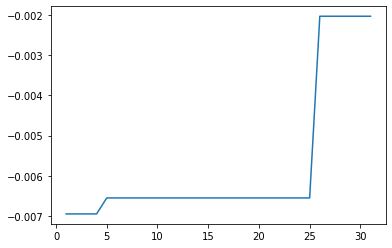

,x1,x2,x3,x4,loss_estimate,iter
0,547.541934,852.458066,852.458066,547.541934,0.006947,0
0,548.606921,851.393079,851.393079,548.606921,0.006550,4
0,548.074361,851.925639,851.925639,548.074361,0.006550,9
0,551.696953,807.304696,851.103226,551.696953,0.007323,24
0,527.814025,823.478848,851.986618,527.814025,0.002031,25
0,526.521650,969.644809,851.810697,526.521650,0.006550,31


In [87]:
df_plot = df.query('iter>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['iter']
y = df_plot['loss_estimate']

plt.plot(x, best_value)
#plt.legend(title='Parameter where:')
plt.show()
df.query('loss_estimate<0.010')

In [88]:
df.to_csv("./data/baxus.csv",index = None)